In [1]:
import gc
import time

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

from pytorch_tabnet.tab_model import TabNetClassifier
import utils

%matplotlib inline

In [2]:
df = pd.read_csv('data/processed_train.csv')
df_test = pd.read_csv('data/processed_test.csv')

In [3]:
CALC_COLUMNS = [col for col in df.columns if 'calc' in col]

df.drop(CALC_COLUMNS, axis=1, inplace=True)
df_test.drop(CALC_COLUMNS, axis=1, inplace=True)
len(df.columns)

39

In [4]:
CATEGORICAL_COLUMNS = [col for col in df.columns if col.endswith('bin') or col.endswith('cat')]
NUMERIC_COLUMNS = [col for col in df.columns if not col.endswith('bin') and not col.endswith('cat')]

# treat low cardinality (<= 3) categorical features as numeric
# CATEGORICAL_COLUMNS = [col for col in df.columns if col.endswith('cat')]
# NUMERIC_COLUMNS = [col for col in df.columns if not col.endswith('cat')]
# for col in ['ps_ind_04_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 
#             'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_10_cat']:
#     CATEGORICAL_COLUMNS.remove(col)
#     NUMERIC_COLUMNS.append(col)

NUMERIC_COLUMNS.remove('id')
NUMERIC_COLUMNS.remove('target')

In [5]:
utils.cast_save_memmory(df, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)
utils.cast_save_memmory(df_test, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)

In [6]:
categorical_dims =  {}
for col in CATEGORICAL_COLUMNS:
    categorical_dims[col] = df[col].nunique()   

In [7]:
features = [col for col in NUMERIC_COLUMNS + CATEGORICAL_COLUMNS] 

cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]

In [8]:
kf = KFold(n_splits=5, shuffle=True)
n_steps = 5
n_d = 8
gamma = 1.5
emb_dim = 1
importance = pd.DataFrame({'features': features})
i = 0
for train_index, valid_index in kf.split(df):
    print(f'{i} fold')
    X_train = df.loc[train_index, NUMERIC_COLUMNS + CATEGORICAL_COLUMNS]
    X_valid = df.loc[valid_index, NUMERIC_COLUMNS + CATEGORICAL_COLUMNS]
    y_train = df.loc[train_index, 'target']
    y_valid = df.loc[valid_index, 'target']

    clf = TabNetClassifier(n_steps=n_steps,
                       n_d=n_d, 
                       n_a=n_d, 
                       gamma=gamma,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=emb_dim,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       mask_type='entmax'
                      )

    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=100 , patience=5,
        batch_size=10000, virtual_batch_size=250,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    
    y_pred = clf.predict_proba(df_test[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS].values)
    sol = pd.read_csv('data/sample_submission.csv')
    sol.iloc[:, 1] = y_pred[:, 1]
    sol.to_csv(f'solutions/tabnet_{n_steps}_{n_d}_{int(gamma*10)}_{emb_dim}_f_{i}.csv', index=False)
    importance[f'fold_{i}'] = clf.feature_importances_
    
    i += 1
    time.sleep(60*5)

0 fold
Device used : cpu
epoch 0  | loss: 0.70984 | train_auc: 0.57441 | valid_auc: 0.57565 |  0:00:51s
epoch 1  | loss: 0.68065 | train_auc: 0.58666 | valid_auc: 0.57985 |  0:01:46s
epoch 2  | loss: 0.67754 | train_auc: 0.59521 | valid_auc: 0.58959 |  0:02:41s
epoch 3  | loss: 0.67531 | train_auc: 0.60981 | valid_auc: 0.60324 |  0:03:41s
epoch 4  | loss: 0.67499 | train_auc: 0.61326 | valid_auc: 0.60538 |  0:04:38s
epoch 5  | loss: 0.67342 | train_auc: 0.61722 | valid_auc: 0.61252 |  0:05:30s
epoch 6  | loss: 0.6731  | train_auc: 0.61525 | valid_auc: 0.61152 |  0:06:23s
epoch 7  | loss: 0.67312 | train_auc: 0.61717 | valid_auc: 0.60996 |  0:07:17s
epoch 8  | loss: 0.67175 | train_auc: 0.61873 | valid_auc: 0.61136 |  0:08:10s
epoch 9  | loss: 0.67121 | train_auc: 0.61933 | valid_auc: 0.61359 |  0:09:03s
epoch 10 | loss: 0.67073 | train_auc: 0.62483 | valid_auc: 0.61592 |  0:09:56s
epoch 11 | loss: 0.67082 | train_auc: 0.62456 | valid_auc: 0.61685 |  0:10:49s
epoch 12 | loss: 0.66992 | 

epoch 21 | loss: 0.66471 | train_auc: 0.638   | valid_auc: 0.62769 |  0:18:48s
epoch 22 | loss: 0.66311 | train_auc: 0.63977 | valid_auc: 0.62742 |  0:19:38s
epoch 23 | loss: 0.66274 | train_auc: 0.64144 | valid_auc: 0.63077 |  0:20:29s
epoch 24 | loss: 0.66164 | train_auc: 0.64147 | valid_auc: 0.6263  |  0:21:19s
epoch 25 | loss: 0.66156 | train_auc: 0.64029 | valid_auc: 0.62702 |  0:22:10s
epoch 26 | loss: 0.66082 | train_auc: 0.64488 | valid_auc: 0.62605 |  0:23:02s
epoch 27 | loss: 0.66003 | train_auc: 0.64642 | valid_auc: 0.62674 |  0:23:53s
epoch 28 | loss: 0.65922 | train_auc: 0.64511 | valid_auc: 0.62323 |  0:24:43s

Early stopping occurred at epoch 28 with best_epoch = 23 and best_valid_auc = 0.63077
Best weights from best epoch are automatically used!


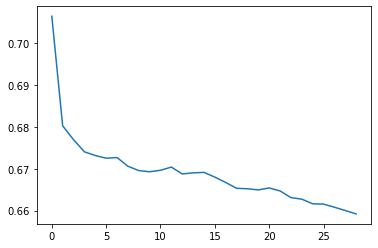

In [9]:
# plot losses
plt.plot(clf.history['loss'])

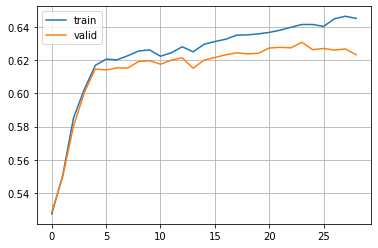

In [10]:
# plot auc
plt.plot(clf.history['train_auc'], label='train')
plt.plot(clf.history['valid_auc'], label='valid')
plt.legend()
plt.grid();

In [11]:
importance

,features,fold_0,fold_1,fold_2,fold_3,fold_4
0,ps_ind_01,0.002805,0.011681,0.014061,0.012697,0.000215
1,ps_ind_03,0.155616,0.110361,0.007864,0.002254,0.019457
2,ps_ind_14,0.001021,0.001782,0.004271,0.000869,0.002135
3,ps_ind_15,0.038896,0.058669,0.021600,0.069504,0.031667
4,ps_reg_01,0.002941,0.037547,0.035480,0.034577,0.046982
5,ps_reg_02,0.004379,0.003904,0.032357,0.030327,0.085054
6,ps_reg_03,0.052132,0.137881,0.032650,0.146185,0.015961
7,ps_car_11,0.002772,0.001485,0.024471,0.000036,0.002731
8,ps_car_12,0.003282,0.005330,0.009732,0.073729,0.007388
9,ps_car_13,0.158799,0.077294,0.100122,0.024168,0.105368
